## Lung Segmenter
by Marsh [ @vbookshelf ]<br>
4 December 2019

<img src="http://lung.test.woza.work/assets/webpage.png" width="600"></img>

<h5 align="center">Output from the web app</h5>

## Introduction

My goal for this exercise was to develop the Python, HTML, CSS and Javascript workflow that would make it possible for a Tensorflow.js web app to display a segmented image inside a web browser. For visual context the segmented image is overlayed on the original image. An example output is shown in the picture above.

This same code structure can be used to build web apps for other problems that combine prediction and segmentation. One drawback I found was that inference takes about 30 seconds when large images are submitted to the app. That's a long time in the web world - online users don't like waiting. This aspect of the user experience needs to be optimized.

In this notebook we will build a Keras model that will take a chest x-ray as input and output a segmented image showing only the lungs. This trained model has been loaded into a Tensorflow.js web app and deployed online.

> Web App<br>
> http://lung.test.woza.work/<br>
> 
> Github<br>
> https://github.com/vbookshelf/Lung-Segmenter

*For best results I suggest using the Chrome browser to run the app.*


## Data Summary

We are working with two Kaggle datasets:<br>

>  **1. Pulmonary Chest X-Ray Abnormalities by Kevin Mader**<br>
>  **2. Lung Masks for Shenzhen Hospital Chest X-ray Set by yoctoman**
  
  

The Pulmonary Chest X-Ray Abnormalities dataset has data from two sources namely, Shenzhen and Montgomery.

 - The Shenzhen data has 662 chest x-ray images.
 - The Montgomery data has 138 chest x-ray images, 138 left lung masks and 138 right lung masks.
 - The Lung Masks for Shenzhen Hospital Chest X-ray dataset has lung masks for 566 of the 662 Shenzhen x-ray images. 



## Approach

- Resize images and masks to 128x128
- Set aside 100 images as a holdout test set.
- Split the remainder of the data into 85% train and 15% validation.
- Use a Keras U-Net model architecture with Adam optimizer and binary crossentropy loss.
- The only pre-processing will be to normalize the images by dividing by 255.
- We won't use any data augmentation.

In [1]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from skimage.io import imread, imshow
from skimage.transform import resize


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.listdir('../input')

['pulmonary-chest-xray-abnormalities', 'shcxr-lung-mask']

In [3]:
NUM_TEST_IMAGES = 100

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNELS = 3

BATCH_SIZE = 100


## What files are available?

In [4]:
# Dataset: pulmonary-chest-xray-abnormalities
# Here only the Montgomery images have masks. The Shenzhen don't have masks.

os.listdir('../input/pulmonary-chest-xray-abnormalities')

['Montgomery', 'ChinaSet_AllFiles']

In [5]:
# Dataset: shcxr-lung-mask dataset
# These are the masks for the Shenzhen images.

os.listdir('../input/shcxr-lung-mask')

['mask']

### What are the labels?
The pulmonary-chest-xray-abnormalities dataset includes labels that specify which x-ray images display signs of tuberculosis and which don't. We will use this target info later when we do a stratified train test split.


The label is part of the file name.

Example: *CHNCXR_0470__**1**.png*<br>

**0** = Normal (No TB)<br>
**1** = TB<br>

Each of the two datasets has a text file containing meta-data.

## Check for non image files

In [6]:
shen_image_list = \
os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
shen_mask_list = os.listdir('../input/shcxr-lung-mask/mask/mask')

mont_image_list = \
os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')
mont_left_mask_list = \
os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask/')
mont_right_mask_list = \
os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/rightMask/')



def find_non_images(image_list):
  
  """
  Checks a list and returns a list of items 
  that are not png images.
  
  """
  
  non_image_list = []
  
  for fname in image_list:
    # split on the full stop
    fname_list = fname.split('.')

    # select the extension
    extension = fname_list[1]

    if extension != 'png':
      non_image_list.append(fname)

  return non_image_list



In [7]:
# Non images in Shenzhen folder
non_images = find_non_images(shen_image_list)

non_images

['Thumbs.db']

In [8]:
# Non images in Shenzhen mask folder
non_images = find_non_images(shen_mask_list)

non_images

[]

In [9]:
# Non images in Montgomery image folder
non_images = find_non_images(mont_image_list)

non_images

['Thumbs.db']

In [10]:
# Non images in Montgomery left mask folder
non_images = find_non_images(mont_left_mask_list)

non_images

['Thumbs.db']

In [11]:
# Non images in Montgomery right mask folder
non_images = find_non_images(mont_right_mask_list)

non_images

[]

### How many images are in each folder?
Note: In the Montgomery images, Montgomery left masks and Shenzhen image folder there is a non image file called 'Thumbs.db'

In [12]:
# Mongomery images
# 138 (excl. Thumbs.db)
print(len(os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')))

# Mongomery left masks
# 138 (excl. Thumbs.db)
print(len(os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask/')))

# Mongomery right masks
# 138
print(len(os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/rightMask/')))



# Shenzhen images
# 662 (excl. Thumbs.db)
print(len(os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')))

# Shenzhen masks
# 566
print(len(os.listdir('../input/shcxr-lung-mask/mask/mask')))

139
139
138
663
566


### Create a Dataframe containing all images

In [13]:
shen_image_list = os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')

mont_image_list = os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')

In [14]:
# put the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# remove the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [15]:
df_shen.head()

,image_id
0,CHNCXR_0616_1.png
1,CHNCXR_0314_0.png
2,CHNCXR_0515_1.png
3,CHNCXR_0221_0.png
4,CHNCXR_0306_0.png


In [16]:
df_mont.head()

,image_id
0,MCUCXR_0243_1.png
1,MCUCXR_0338_1.png
2,MCUCXR_0196_1.png
3,MCUCXR_0017_0.png
4,MCUCXR_0393_1.png


In [17]:
# Put the Shenzhen masks into a dataframe

shen_mask_list = os.listdir('../input/shcxr-lung-mask/mask/mask')

df_shen_masks = pd.DataFrame(shen_mask_list, columns=['mask_id'])

# create a new column with the image_id that corresponds to each mask

# example mask_id: CHNCXR_0001_0_mask.png

def create_image_id(x):
  
  # split on '_mask'
  fname_list = x.split('_mask')
  image_id = fname_list[0] + fname_list[1]
  
  return image_id
  
# create a new column
df_shen_masks['image_id'] = df_shen_masks['mask_id'].apply(create_image_id)

df_shen_masks.head()

,mask_id,image_id
0,CHNCXR_0385_1_mask.png,CHNCXR_0385_1.png
1,CHNCXR_0635_1_mask.png,CHNCXR_0635_1.png
2,CHNCXR_0278_0_mask.png,CHNCXR_0278_0.png
3,CHNCXR_0613_1_mask.png,CHNCXR_0613_1.png
4,CHNCXR_0135_0_mask.png,CHNCXR_0135_0.png


We don't have masks for all Shenzhen images. Therefore, let's remove images from df_shen that don't have masks. We will do this by doing a dataframe merge. This will only keep rows that are common to both dataframes. Therefore, image_id's that are not in df_shen_masks will be removed from the new merged dataframe.

In [18]:
df_shen = pd.merge(df_shen, df_shen_masks, on='image_id')

df_shen.head()

,image_id,mask_id
0,CHNCXR_0616_1.png,CHNCXR_0616_1_mask.png
1,CHNCXR_0314_0.png,CHNCXR_0314_0_mask.png
2,CHNCXR_0515_1.png,CHNCXR_0515_1_mask.png
3,CHNCXR_0221_0.png,CHNCXR_0221_0_mask.png
4,CHNCXR_0306_0.png,CHNCXR_0306_0_mask.png


In [19]:
df_shen.shape

(566, 2)

### Assign labels to the images

In [20]:
# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.

def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [21]:
# Assign the target labels

df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)


### Check the class distribution

In [22]:
# Shenzen Dataset

df_shen['target'].value_counts()

Tuberculosis    287
Normal          279
Name: target, dtype: int64

In [23]:
# Montgomery Dataset

df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

### Display a ramdom sample of images from each dataset by target

In [24]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

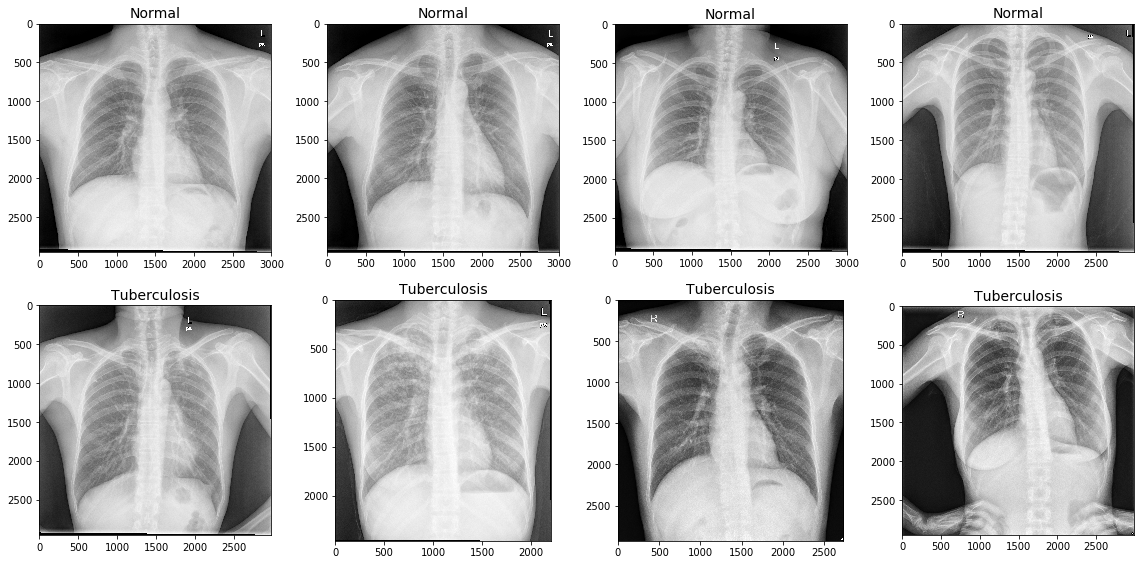

In [25]:
# Shenzen Dataset

IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'

draw_category_images('target',4, df_shen, IMAGE_PATH)

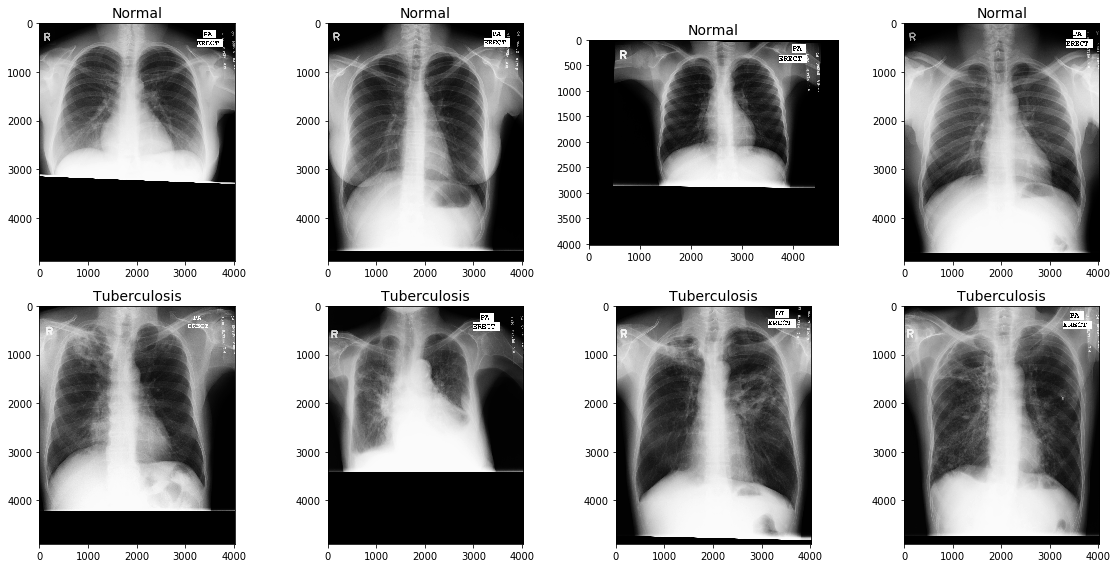

In [26]:
# Montgomery Dataset

IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'

draw_category_images('target',4, df_mont, IMAGE_PATH)

### What is the shape of each image and what are its max and min pixel values?
Let's include all this info in the dataframes we created above.

In [27]:
def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[2] represents the number of channels: (height, width, num_channels).
    # Here we are saying: If the shape does not have a value for num_channels (height, width)
    # then assign 1 to the number of channels.
    if len(image.shape) > 2: # i.e. more than two numbers in the tuple
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output



In [28]:
IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'

m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,mask_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0616_1.png,CHNCXR_0616_1_mask.png,Tuberculosis,2465,2235,3,255,0
1,CHNCXR_0314_0.png,CHNCXR_0314_0_mask.png,Normal,2955,2689,3,255,0
2,CHNCXR_0515_1.png,CHNCXR_0515_1_mask.png,Tuberculosis,2945,2450,3,255,0
3,CHNCXR_0221_0.png,CHNCXR_0221_0_mask.png,Normal,2928,2464,3,255,0
4,CHNCXR_0306_0.png,CHNCXR_0306_0_mask.png,Normal,2931,3000,3,255,0


In [29]:
IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'

m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0243_1.png,Tuberculosis,4020,4892,3,255,0
1,MCUCXR_0338_1.png,Tuberculosis,4892,4020,3,253,0
2,MCUCXR_0196_1.png,Tuberculosis,4892,4020,3,255,0
3,MCUCXR_0017_0.png,Normal,4020,4892,3,255,0
4,MCUCXR_0393_1.png,Tuberculosis,4892,4020,3,255,0


### How many channels do the images in each dataset have?

In [30]:
df_shen['c'].value_counts()

3    566
Name: c, dtype: int64

In [31]:
df_mont['c'].value_counts()

3    138
Name: c, dtype: int64

We see that all images have 3 channels. The images have a pixel value range between 0 and 255.

## Display one Montgomery image and mask
In the Mongomery dataset there are separate masks for the left lung and right lung. We will combine these two masks into one by simply adding the matrices. Each mask has the same file name as it's corresponding image.

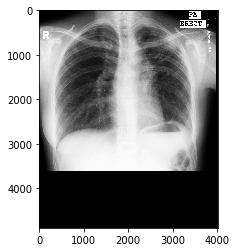

In [32]:
# print a Montgomery image and mask

# image
index = 2
fname = df_mont.loc[index, 'image_id']
path = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/' + fname
# read the image as a matrix
image = plt.imread(path)

plt.imshow(image, cmap='gray')

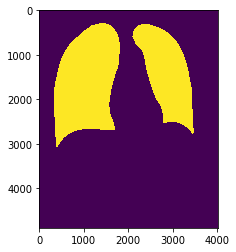

In [33]:
fname = df_mont.loc[index, 'image_id']


# left mask
path = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask/' + fname
left_mask = plt.imread(path)

# right mask
path = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/rightMask/' + fname
right_mask = plt.imread(path)

# combine both masks
mask = left_mask + right_mask

plt.imshow(mask)

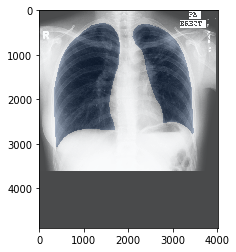

In [34]:
# display the Montgomery image and mask

plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.3)

## Display one Shenzhen image and mask

Each Shenzhen image file name has the following format:
CHNCXR_0001_0.png


The corresponding mask file name has the following format: CHNCXR_0001_0_mask.png

Each mask includes both the left and right lungs.

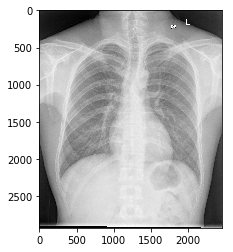

In [35]:
# print a Shenzhen image and mask

# image
index = 3
fname = df_shen.loc[index, 'image_id']
path = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/' + fname

# read the image as a matrix
image = plt.imread(path)

plt.imshow(image, cmap='gray')

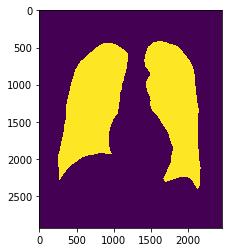

In [36]:
fname = df_shen.loc[index, 'image_id']

mask_name = fname.split('.')
mask_name = mask_name[0] + '_mask.png'


# left mask
path = '../input/shcxr-lung-mask/mask/' + mask_name
mask = plt.imread(path)


plt.imshow(mask)

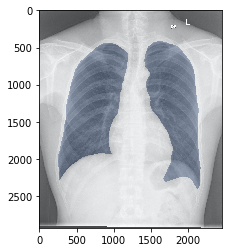

In [37]:
# display the Shenzhen image and mask

plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.3)

### Create a dataframe containing all images

In [38]:
### Combine the two dataframes and shuffle

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


(704, 8)

In [39]:
# Create a new column called 'labels' that maps the classes to binary values.
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [40]:
df_data.head()

,c,h,image_id,mask_id,max_pixel_val,min_pixel_val,target,w,labels
179,3,2344,CHNCXR_0377_1.png,CHNCXR_0377_1_mask.png,255,0,Tuberculosis,2730,1
440,3,2796,CHNCXR_0092_0.png,CHNCXR_0092_0_mask.png,255,0,Normal,2652,0
227,3,2478,CHNCXR_0127_0.png,CHNCXR_0127_0_mask.png,255,0,Normal,2382,0
67,3,1233,CHNCXR_0075_0.png,CHNCXR_0075_0_mask.png,255,0,Normal,1110,0
52,3,2751,CHNCXR_0121_0.png,CHNCXR_0121_0_mask.png,255,0,Normal,2990,0


## Create a holdout test set

This will be set aside and won't be used during training and validation. We will use it later to check how the trained model performs on unseen data.

In [41]:
# create a test set
df_test = df_data.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_data = df_data[~df_data['image_id'].isin(test_images_list)]

print(df_data.shape)
print(df_test.shape)

(604, 9)
(100, 9)


## Train Test Split

In [42]:
# train_test_split

# We will stratify by target (TB or Normal)

y = df_data['labels']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(513, 9)
(91, 9)


In [43]:
df_train['target'].value_counts()

Normal          267
Tuberculosis    246
Name: target, dtype: int64

In [44]:
df_val['target'].value_counts()

Normal          47
Tuberculosis    44
Name: target, dtype: int64

## Save the dataframes as compressed csv files

These csv files will allow us to use Pandas chunking to feed images into the generators.

In [45]:
df_data.to_csv('df_data.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)


In [46]:
# check if the files were saved
!ls

__notebook__.ipynb  df_data.csv.gz  df_train.csv.gz
__output__.json     df_test.csv.gz  df_val.csv.gz


## Move all the images into the same directory

In [47]:
# Create a new directory
image_dir = 'image_dir'
os.mkdir(image_dir)

In [48]:
%%time

# Get a list of train and val images
shen_image_list = list(df_shen['image_id'])
mont_image_list = list(df_mont['image_id'])



# Transfer the Shenzhen images

for image_id in shen_image_list:   
    
    fname = image_id
    
    path = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/' + fname
    # read the image
    image = cv2.imread(path)
    
    # convert to from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resize the image
    image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    # save the image
    path = 'image_dir/' + fname
    cv2.imwrite(path, image)



    
# Transfer the Montgomery images

for image_id in mont_image_list: 
  
    fname = image_id
    
    path = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/' + fname
    # read the image
    image = cv2.imread(path)
    
    # convert to from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resize the image
    image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    # save the image
    path = 'image_dir/' + fname
    cv2.imwrite(path, image)
    
    

CPU times: user 1min 20s, sys: 4.4 s, total: 1min 25s
Wall time: 1min 22s


## Move all masks into the same directory

In [49]:
# Create a new directory
mask_dir = 'mask_dir'
os.mkdir(mask_dir)

In [50]:
%%time

# Get a list of train and val images
shen_mask_list = list(df_shen['mask_id'])
mont_mask_list = list(df_mont['image_id'])



# Transfer the Shenzhen masks
# These masks have file names that are not the same as the images

for image in shen_mask_list:
    
    
    fname = image
    
    # change the mask file name to be the same as the image_id
    fname_list = fname.split('_mask')
    new_fname = fname_list[0] + fname_list[1]
    
    path = '../input/shcxr-lung-mask/mask/' + fname
    # read the image
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    # resize the mask
    mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    # save the mask
    path = 'mask_dir/' + new_fname
    cv2.imwrite(path, mask)



CPU times: user 17 s, sys: 124 ms, total: 17.1 s
Wall time: 18.6 s


In [51]:
%%time

# Transfer the Montgomery masks

for image in mont_mask_list:
    
    
    fname = image
    
    
    # left mask
    path = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask/' + fname
    left_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # right mask
    path = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/rightMask/' + fname
    right_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # combine left and right masks
    mask = left_mask + right_mask
    
    # resize the mask
    mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    
    # save the combined mask
    path = 'mask_dir/' + fname
    cv2.imwrite(path, mask)
    

CPU times: user 9.98 s, sys: 76 ms, total: 10.1 s
Wall time: 10.7 s


## Build the Data Generators

The ouput from a generator does not accumulate in memory. Each output batch overwrites the last one. This means that we can feed large amounts of data into a model without running out of RAM and crashing the kernel. There's a 13GB RAM limit when using a GPU.

We will use Pandas chunking and the compressed csv files to feed data into the generators. Using chunking simplifies the code. For example, the last batch that is fed into a generator will be smaller than the others. Pandas chunking will handle this change in batch size automatically which means that we won't need to write code to handle this condition.

Chunking is very useful when the csv file data is too large to be loaded into memory i.e. into a single Pandas dataframe.

If you would like to understand how generators work please refer to this notebook:<br>
https://www.kaggle.com/vbookshelf/python-generators-to-reduce-ram-usage-part-2


### [ 1 ] Train Generator

In [52]:
def train_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image_id'])
            mask_id_list = list(df['image_id'])
            
            # Create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)

        
            
            # Create X_train
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                #image = resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
                
                # insert the image into X_train
                X_train[i] = image
            
            
            # Create Y_train
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                # resize the mask
                #mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
                
                
                # insert the image into Y_train
                Y_train[j] = mask
                
                
            # Normalize the images
            X_train = X_train/255

            yield X_train, Y_train

In [53]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=10)

# run the generator
X_train, Y_train = next(train_gen)

print(X_train.shape)
print(Y_train.shape)

(10, 128, 128, 3)
(10, 128, 128, 1)


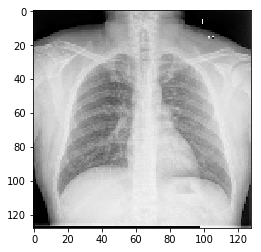

In [54]:
# print the first image in X_train

img = X_train[7,:,:,:]
plt.imshow(img)

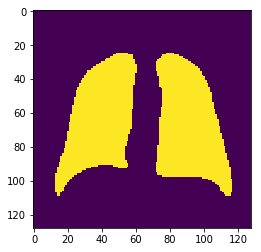

In [55]:
# print the first mask in Y_train

msk = Y_train[7,:,:,0]
plt.imshow(msk)

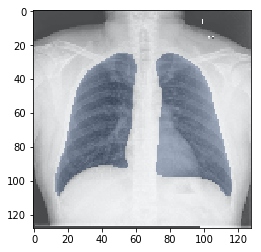

In [56]:
plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.3)

### [ 2 ] Val Generator

In [57]:
def val_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image_id'])
            mask_id_list = list(df['image_id'])
            
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)

        
            
            # Create X_val
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                #image = resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
                
                # insert the image into X_train
                X_val[i] = image
            
            
            # Create Y_val
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                # resize the mask
                #mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
                
                
                # insert the image into Y_train
                Y_val[j] = mask
                
            
            # Normalize the images
            X_val = X_val/255
            
            yield X_val, Y_val

In [58]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=10)

# run the generator
X_val, Y_val = next(val_gen)

print(X_val.shape)
print(Y_val.shape)

(10, 128, 128, 3)
(10, 128, 128, 1)


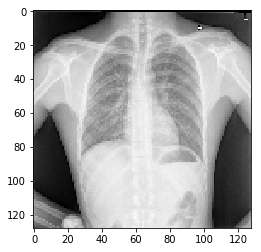

In [59]:
# print the image from X_val

img = X_val[7,:,:,:]
plt.imshow(img)

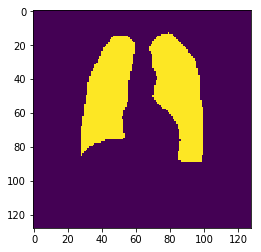

In [60]:
# print the mask from Y_val

msk = Y_val[7,:,:,0]
plt.imshow(msk)

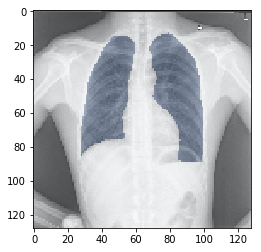

In [61]:
# Combine the mask and the image

plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.3)

### [ 3 ] Test Generator

In this test generator we will output both the test images (X_test) and the test masks (Y_test). 

In [62]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_test.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image_id'])
            mask_id_list = list(df['image_id'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            


            
            # Create X_test
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
           
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                #image = resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
                
                # insert the image into X_train
                X_test[i] = image
                
             
            # Create Y_test
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                # resize the mask
                #mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
                
                
                # insert the image into Y_train
                Y_test[j] = mask
            
            
            # Normalize the images
            X_test = X_test/255
            
            yield X_test, Y_test


In [63]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=5)

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


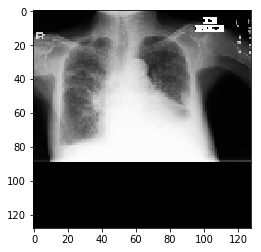

In [64]:
# print the image from X_test

img = X_test[1,:,:,:]
plt.imshow(img)

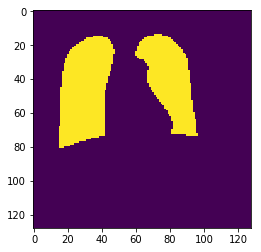

In [65]:
# print the mask from Y_test

msk = Y_test[1,:,:,0]
plt.imshow(msk)

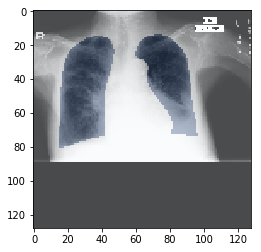

In [66]:
# Combine the mask and the image

plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.3)

## Model Architecture

In [67]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)


from keras.optimizers import Adam
from keras.losses import binary_crossentropy

from keras.initializers import he_normal 

import tensorflow as tf

Using TensorFlow backend.


U-Net seems to be quite sensitive to the initialization weights. This means that every time a model is run the quality of the output segmentations will be different. They are sometimes good and sometimes very poor.To solve this problem I've added a seed to each of the layers to try to fix the initial weights.

In [68]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

drop_out = 0.1
INIT_SEED = 101



inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Note: Tensorflow.js does not support lambda layers.
#s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (inputs)
c1 = Dropout(drop_out) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (p1)
c2 = Dropout(drop_out) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (p2)
c3 = Dropout(drop_out) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (p3)
c4 = Dropout(drop_out) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (p4)
c5 = Dropout(drop_out) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (u6)
c6 = Dropout(drop_out) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (u7)
c7 = Dropout(drop_out) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (u8)
c8 = Dropout(drop_out) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (u9)
c9 = Dropout(drop_out) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer=he_normal(seed=INIT_SEED), padding='same') (c9)


outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        dropout_1[0][0]                  
____________________________________________________________________________________________

## Create X_test
Here we will use the test generator with a batch size of len(df_test) to create X_test and Y_test. Because the batch size is equal to the number of rows in df_test, the generator will ouput the entire
test set (100 rows) as a matrix.

In [69]:
# initialize
test_gen = test_generator(batch_size=len(df_test))

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

(100, 128, 128, 3)
(100, 128, 128, 1)


## Train the Model

In [70]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [71]:
# Initialize the generators
train_gen = train_generator(batch_size=BATCH_SIZE)
val_gen = val_generator(batch_size=BATCH_SIZE)



filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, earlystopper, csv_logger, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=40, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

Epoch 1/40
6/6 [==============================] - 8s 1s/step - loss: 0.6443 - val_loss: 0.5174

Epoch 00001: val_loss improved from inf to 0.51744, saving model to model.h5
Epoch 2/40
6/6 [==============================] - 1s 142ms/step - loss: 0.5179 - val_loss: 0.4841

Epoch 00002: val_loss improved from 0.51744 to 0.48407, saving model to model.h5
Epoch 3/40
6/6 [==============================] - 1s 145ms/step - loss: 0.3615 - val_loss: 0.2317

Epoch 00003: val_loss improved from 0.48407 to 0.23166, saving model to model.h5
Epoch 4/40
6/6 [==============================] - 1s 145ms/step - loss: 0.2160 - val_loss: 0.2112

Epoch 00004: val_loss improved from 0.23166 to 0.21116, saving model to model.h5
Epoch 5/40
6/6 [==============================] - 1s 147ms/step - loss: 0.1579 - val_loss: 0.1427

Epoch 00005: val_loss improved from 0.21116 to 0.14273, saving model to model.h5
Epoch 6/40
6/6 [==============================] - 1s 143ms/step - loss: 0.1238 - val_loss: 0.1117

Epoch 00

## Make a test set prediction

In [72]:
# Make a prediction

# initialize the test generator
test_gen = test_generator(batch_size=1)

model.load_weights('model.h5')
predictions = model.predict_generator(test_gen, 
                                      steps=len(df_test),  
                                      verbose=1)

100/100 [==============================] - 1s 9ms/step


In [73]:
!ls

__notebook__.ipynb  df_test.csv.gz   image_dir	training_log.csv
__output__.json     df_train.csv.gz  mask_dir
df_data.csv.gz	    df_val.csv.gz    model.h5


### Threshold the predictions

The predictions are actually probabilities that a pixel is either part of a lung or part of the background. Here we threshold the predictions to convert all values to either 0 or 1.

We will use a threshold of 0.7. I got this number by trial and error - try a threshold value and look at the quality of the test set segmentations. 

In [74]:
preds_test_thresh = (predictions >= 0.7).astype(np.uint8)

preds_test_thresh.shape

print(preds_test_thresh.min())
print(preds_test_thresh.max())

0
1


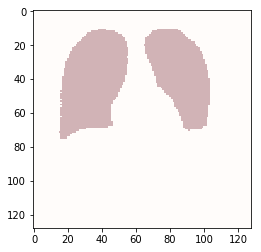

In [75]:
# This is a predicted mask

mask = preds_test_thresh[3,:,:,0]
plt.imshow(mask, cmap='Reds', alpha=0.3)

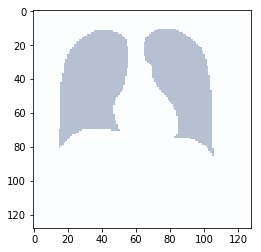

In [76]:
# This is a true mask

true_mask = Y_test[3,:,:,0]
plt.imshow(true_mask, cmap='Blues', alpha=0.3)

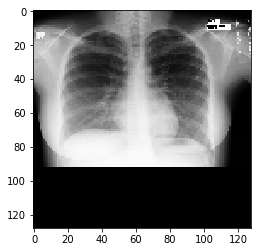

In [77]:
# This is the x-ray image

image = X_test[3,:,:,:]

plt.imshow(image)

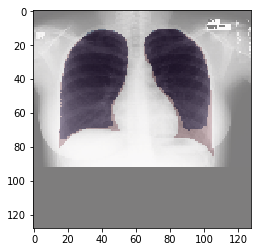

In [78]:
# This is an overlay of the pred mask, true mask and 
# the x-ray image.

plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)

## Overlay pred masks, true masks and the x-ray image

Red - True Mask<br>
Blue - Pred Mask

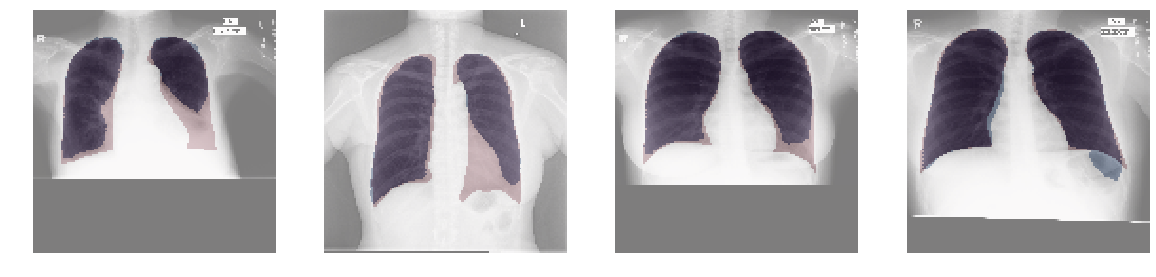

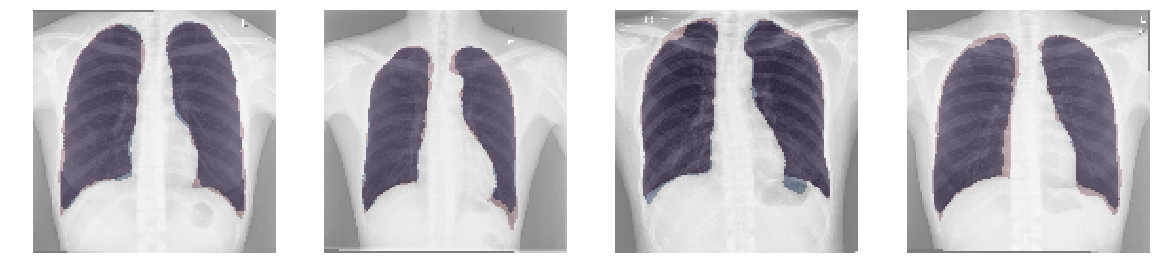

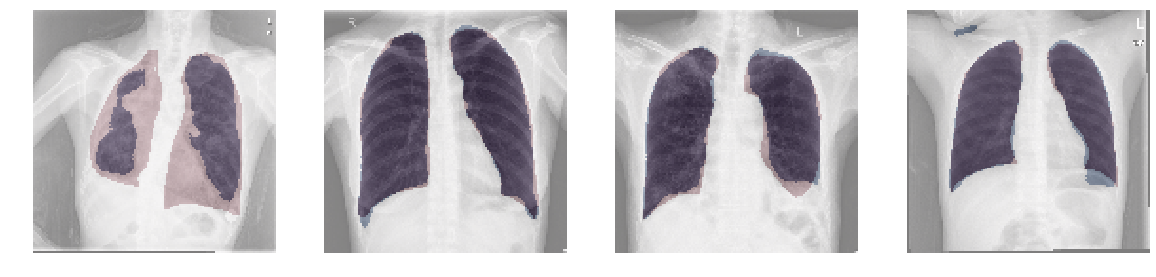

In [79]:
# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')

predicted_masks = preds_test_thresh



    
# image
plt.subplot(1,4,1)
image = X_test[1,:,:,:] 
mask = predicted_masks[1, :, :, 0]
true_mask = Y_test[1, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,2)
image = X_test[2,:,:,:] 
mask = predicted_masks[2, :, :, 0]
true_mask = Y_test[2, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test[3,:,:,:]
mask = predicted_masks[3, :, :, 0]
true_mask = Y_test[3, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,4)
image = X_test[4,:,:,:] 
mask = predicted_masks[4, :, :, 0]
true_mask = Y_test[4, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')



# ============ #


# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')


# image
plt.subplot(1,4,1)
image = X_test[5,:,:,:] 
mask = predicted_masks[5, :, :, 0]
true_mask = Y_test[5, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,2)
image = X_test[6,:,:,:] 
mask = predicted_masks[6, :, :, 0]
true_mask = Y_test[6, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test[7,:,:,:] 
mask = predicted_masks[7, :, :, 0]
true_mask = Y_test[7, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,4)
image = X_test[8,:,:,:] 
mask = predicted_masks[8, :, :, 0]
true_mask = Y_test[8, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# ============ #


# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')


# image
plt.subplot(1,4,1)
image = X_test[9,:,:,:] 
mask = predicted_masks[9, :, :, 0]
true_mask = Y_test[9, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,2)
image = X_test[10,:,:,:] 
mask = predicted_masks[10, :, :, 0]
true_mask = Y_test[10, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test[11,:,:,:] 
mask = predicted_masks[11, :, :, 0]
true_mask = Y_test[11, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,4)
image = X_test[12,:,:,:] 
mask = predicted_masks[12, :, :, 0]
true_mask = Y_test[12, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


plt.show()

## Results

The results look fine. There's a clear separation between both lungs. Since we are only using the predictions to demonstrate how the app works, the quality of these segmentations is adequate for our needs. 

## Convert the Model to Tensorflow.js

In [80]:
# --ignore-installed is added to fix an error.

# https://stackoverflow.com/questions/49932759/pip-10-and-apt-how-to-avoid-cannot-uninstall
# -x-errors-for-distutils-packages

!pip install tensorflowjs --ignore-installed

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 17.3MB 13.5MB/s 
     |████████████████████████████████| 412.3MB 27kB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 2.8MB 34.3MB/s 
     |████████████████████████████████| 256kB 39.0MB/s 
     |████████████████████████████████| 901kB 37.5MB/s 
     |████████████████████████████████| 645kB 38.8MB/s 
     |████████████████████████████████| 1.3MB 38.5MB/s 
     |████████████████████████████████| 512kB 33.4MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 112kB 39.3MB/s 
     |████████████████████████████████| 3.8MB 36.5MB/s 
     |████████████████████████████████| 2.4MB 31.8MB/s 
     |████████████████████████████████| 583kB 37.5MB/s 
   

In [81]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras model.h5 tfjs/model

In [82]:
# check that the folder containing the tfjs model files has been created
!ls

__notebook__.ipynb  df_test.csv.gz   image_dir	tfjs
__output__.json     df_train.csv.gz  mask_dir	training_log.csv
df_data.csv.gz	    df_val.csv.gz    model.h5


In [83]:
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

if os.path.isdir('image_dir') == True: # return true if the directory exists
    
    shutil.rmtree('image_dir')
    

if os.path.isdir('mask_dir') == True: # return true if the directory exists
    
    shutil.rmtree('mask_dir')

## Reference Kernels

- Keras U-Net starter - LB 0.277<br>
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

- Python Generators to reduce RAM usage [ Part 2 ]<br>
https://www.kaggle.com/vbookshelf/python-generators-to-reduce-ram-usage-part-2

- Selfie Segmenter - Keras and Unet<br>
https://www.kaggle.com/vbookshelf/selfie-segmenter-keras-and-u-net

## Conclusion

Many thanks to Kevin Mader and to yoctoman for making this data available on Kaggle.

If you would like to learn how to build apps like this I recommend this video tutorial:<br>
https://www.youtube.com/watch?v=HEQDRWMK6yY

I've also included a few practical tips on the readme page in this repo:<br>
https://github.com/vbookshelf/Skin-Lesion-Analyzer

Thank you for reading.